# Notebook 1 - Preprocessing of metabolomic data acquired from plasma samples from COVID patients. 

#### This notebook is a part of a project with the Center for Systems Biology at the University of Iceland. The goal is to take raw metabolomic data (in negative acidic mode, positive acidic mode, and negative basic mode) that was run through XCMS, run it through QC-RLSC signal correction to account for signal drift in the LC-MS, remove too variable variables (according to QC samples), remove outlier samples, perform batch effect correction, scale the data and finally join the three metabolomic modes into a single dataframe to use for downstream analysis.

In [1]:
import pandas as pd
import numpy as np
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
from combat.pycombat import pycombat
import itertools
import kneed
import sklearn
import random
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from kneed import KneeLocator
from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import KFold
import statsmodels.api as sm
import re

## Define functions:

In [2]:
def crop_filter_features(dat,min_rt,min_mz):
    '''
    This is the first step in the pre-processing - the removal of features which we are not interested in (fragments or junk 
    eluting from column in the beginning)
    '''
    dat2 = dat.copy()
    dat2 = dat2[dat2['mz'] > min_mz].reset_index()
    dat2 = dat2[dat2['rt'] > min_rt].reset_index()
    return dat2

def coef_var(array):
    value = (np.std(array)/np.mean(array))*100
    return value

def remove_unwanted_features(data_qc_normalised,is_data,data_original,coef_var_threshold,d_ratio_threshold):
    '''
    Again, needs to have that specific structure (first four columns metadata). 
    This function removes features that have too high variation in the QC samples (above coef_var_threshold)
    and features that have too high variation in the qc samples COMPARE to the biological samples (D-ratio above d_ratio_threshold)
    
    
    '''
    data_qc_normalised2 = data_qc_normalised.copy()
    #data_qc_is_normalised2 = data_qc_is_normalised.copy()
    data_original2 = data_original.copy()
    
    # Remove IS from qc and orig data:
    data_qc_normalised2 = data_qc_normalised2.loc[:,~data_qc_normalised2.columns.isin(is_data['mz_name'])]
    data_original2 = data_original2.loc[:,~data_original2.columns.isin(is_data['mz_name'])]
    
    # Extract the QC samples:
    dat_orig = data_original2[data_original2['QC'] == 1]
    dat_norm = data_qc_normalised2[data_qc_normalised2['QC'] == 1]
    #dat_norm2 = data_qc_is_normalised2[data_qc_is_normalised2['QC'] == 1]

    norm_cv = []
    #norm2_cv = []
    orig_cv = []
    for columnn in range (4,dat_norm.shape[1]):
        norm_cv.append(coef_var(dat_norm.iloc[:,columnn]))
        #norm2_cv.append(coef_var(dat_norm2.iloc[:,columnn]))
        orig_cv.append(coef_var(dat_orig.iloc[:,columnn]))


    df = pd.DataFrame([orig_cv+norm_cv,['Original']*len(orig_cv)+['QC-Normalised']*len(norm_cv)]).T
    df.columns = ['Value','Type']
    mean_normal = np.nanmedian(norm_cv)
    #mean_normal2 = np.nanmedian(norm2_cv)
    mean_orig = np.nanmedian(orig_cv)
    figg = sns.kdeplot(data=df, x="Value", hue="Type",alpha = .5,fill = True)
    plt.axvline(x=mean_normal,color='orange',ls = '--')
    plt.axvline(x=mean_orig,color='blue',ls = '--')
    #plt.axvline(x=mean_normal2,color='green',ls = '--')
    plt.xlim([0, 100])
    plt.show()
    
    # Return the ids of the features with more than "coef_var_threshold" coef of variation:
    id_remove = [idxx + 4 for (idxx,x) in enumerate(norm_cv) if x > coef_var_threshold]
    data_normalised_out = data_qc_normalised2.drop(data_qc_normalised2.columns[id_remove],axis=1)
    data_original_out = data_original2.drop(data_original2.columns[id_remove],axis=1)
    
    # Calculate D-ratio of remaining features. This applies only too normalised features:
    #dat_orig2_qc = data_original_out[data_original_out['QC'] == 1]
    dat_norm2_qc = data_normalised_out[data_normalised_out['QC'] == 1]
    
    #dat_orig2_nonqc = data_original_out[data_original_out['QC'] == 0]
    dat_norm2_nonqc = data_normalised_out[data_normalised_out['QC'] == 0]
    
    d_ratio_normalised = []
    for columnn in range (4,dat_norm2_qc.shape[1]):
        tmp_val = (np.std(dat_norm2_qc.iloc[:,columnn])/np.std(dat_norm2_nonqc.iloc[:,columnn]))*100
        d_ratio_normalised.append(tmp_val)
    
    # Return the ids of the features with more than "d_ratio_threshold" D-ratio:
    id_remove2 = [idxx + 4 for (idxx,x) in enumerate(d_ratio_normalised) if x > d_ratio_threshold]
    data_normalised_out2 = data_normalised_out.drop(data_normalised_out.columns[id_remove2],axis=1)
    data_original_out2 = data_original_out.drop(data_original_out.columns[id_remove2],axis=1)
    
    return data_normalised_out2, data_original_out2

def outlier_detection_and_removal(data, s):
    '''
    The data structure needs to be the same as for the QC-RLSC (first four columns are metadata). This uses DBSCAN to detect 
    outliers. 
    s is the sensitivity to knee detection in the distance graph. 
    '''
    data2 = data.copy()
    dat_norm_pca = data2.iloc[:,4:]
    #dat_norm_pca = glog(dat_norm_pca)
    dat_norm_pca.index = data2['MS_id']
    scaler2 = StandardScaler()
    norm_scaled = scaler2.fit_transform(dat_norm_pca)
    
    # Perform PCA:
    pca2 = PCA(n_components = 0.99)
    norm_pca = pca2.fit_transform(norm_scaled)
    
    # Find optimal eps value for DBSCAN:
    neigh = NearestNeighbors(n_neighbors=5)
    nbrs = neigh.fit(norm_scaled)
    distances, indices = nbrs.kneighbors(norm_scaled)

    # Prepare distances for plotting:
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]

    # Find "knee" in distances:
    kn = KneeLocator(range(0,len(distances)), distances, curve='convex', direction='increasing', S = s)
    
    if kn.knee is not None:
    # Value to compare to as knee:
        knee = kn.knee_y*1.3

        # Plot the eps values and the identified knee:
        plt.plot(distances)
        plt.axvline(x = kn.knee, color = 'r', linestyle = 'dashed') 
        plt.axhline(y = kn.knee_y, color = 'r', linestyle = 'dashed') 
        plt.show()

        # Find the outliers given the 
        model = DBSCAN(eps=knee, min_samples=5).fit(norm_scaled)
        colors = ['royalblue', 'navy', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'red']
        vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

        # Use the PCA to plot scatterplot:
        plt.scatter(norm_pca.T[0],norm_pca.T[1], c=vectorizer(model.labels_))
        plt.show()

        samples_to_remove = np.where(model.labels_ == -1)[0].tolist()
        out_dat = data2.drop(samples_to_remove)
        out_dat.reset_index()
    else:
        print('No knee detected. No outliers were removed')
        out_dat = data2
    return out_dat


def PCA_visualisation(data):
    '''
    Needs to have that same structure as rest of functions. 
    '''
    #dat_norm_pca = glog(data.iloc[:,4:])
    dat_norm_pca = data.iloc[:,4:]
    scaler1 = StandardScaler()
    norm_scaled = scaler1.fit_transform(dat_norm_pca)
    pca1 = PCA(n_components=0.95)
    norm_pca = pca1.fit_transform(norm_scaled)

    # Create df with labelelled QC:
    df_pca = pd.DataFrame([data['Batch'].tolist(),data['QC'].tolist(),norm_pca.T[0],norm_pca.T[1]]).T
    df_pca.columns = ['Batch','QC','PC1','PC2']

    figg = sns.scatterplot(x = df_pca['PC1'],y = df_pca['PC2'],hue = df_pca['QC'],style = df_pca['Batch'])
    plt.show()
    return

def match_ms_samples_to_patients(normalised_data,ms_info):
    list_of_patients = normalised_data['MS_id'].tolist()
    dict_patients = dict(zip(ms_info['MS_RAW'],ms_info['SAMPLE_ID']))
    ordered_patient_ids = [dict_patients[x] for x in list_of_patients]
    assert len(ordered_patient_ids) == len(list_of_patients)
    out_data = normalised_data.copy()
    out_data['MS_id'] = ordered_patient_ids
    out_data.rename(columns = {'MS_id':'patient_id'}, inplace = True)
    return out_data

glog = lambda x: np.log2((x+np.sqrt(x**2+1))/2)

def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

def tuple_pairs_from_list(lst):
        temp_list = [(el1, el2) for el1 in lst for el2 in lst if el1!=el2]
        res = list({*map(tuple, map(sorted, temp_list))})
        return res

def identify_extremely_similar_peaks(normalised_peak_data,corr_thresh,ppm_thresh):
    cor_matrix = normalised_peak_data.corr()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
    similar_pairs = []
    for idxx,column in enumerate(upper_tri.columns):
        if any(upper_tri[column] > corr_thresh):
            id_high_correlation = np.where(upper_tri[column] > corr_thresh)[0].tolist()
            # Now try out which of the high correlation pairs have a mz difference of > 3 ppm:
            for id_ in id_high_correlation:
                orig_name_list = [x for x in upper_tri.iloc[np.where(upper_tri[column] > corr_thresh)[0].tolist(),id_].index.tolist()]
                # NEED TO USE REGEX TO GET THE NUMERIC VALUE HERE...
                tmp_list = [float(re.findall('\d+.\d+', x)[0]) for x in orig_name_list]
                #tmp_list = [float(x[7:]) for x in orig_name_list]
                diff_list = [(abs(j-i)/j)*1000000 for i,j in zip(tmp_list, tmp_list[1:])] # calculate ppm difference of peaks
                if any(np.array(diff_list) < ppm_thresh):
                    #print('identified pair')
                    #print([x for x in diff_list if x < ppm_thresh])
                    matching_pairs = [(orig_name_list[idxx], orig_name_list[idxx+1]) for idxx,x in enumerate(diff_list) if x < ppm_thresh]
                    #matching_pairs = [orig_name_list[idxx] for idxx,x in enumerate(diff_list) if x < ppm_thresh]
                    
                    #print(matching_pairs)
                    similar_pairs.extend(matching_pairs)
    output_list = []
    for x in similar_pairs:
        if x not in output_list:
            output_list.append(x)
            
    # Remove triple pairs and convert to pairs:
    tuples_to_add = []
    stuff_to_remove = []
    for x in output_list:
        if isinstance(x,list):
            temp_matches = tuple_pairs_from_list(x)
            tuples_to_add.append(temp_matches)
            stuff_to_remove.append(x)
    for vall in stuff_to_remove:
        output_list.drop(vall)
    output_list.extend(tuples_to_add)
    #print(tuples_to_add)
    return output_list

def replace_identical_peaks_with_average(normalised_peak_data,list_peaks,rt_info_data):
    list_of_similar_peaks = list_peaks.copy()
    normalised_peak_data_copy = normalised_peak_data.copy()
    # First go through list of peaks to identify if any one is highly similar to more than 1 other peak:
    unique_values = unique(list(itertools.chain.from_iterable([list(x) for x in list_of_similar_peaks])))
    new_tuples = []
    old_tuples = []

    for idxx_,unique_peak in enumerate(unique_values):
        list_of_matching_tuples = [item for item in list_of_similar_peaks if unique_peak in item]
        if len(list_of_matching_tuples) > 1:
            # Create new tuple containing all these peaks:
            new_tuple = sorted(tuple(unique(tuple(itertools.chain.from_iterable([list(x) for x in list_of_matching_tuples])))))
            # Add the new tuple to the list of new tuples:
            new_tuples.append(new_tuple)
            old_tuples.extend(list_of_matching_tuples)


    new_tuples = unique(new_tuples)  
    new_tuples = [tuple(x) for x in new_tuples]
    old_tuples = unique(old_tuples)
    #print(new_tuples)
    for ele in old_tuples:
        list_of_similar_peaks.remove(ele)
    list_of_similar_peaks.extend(new_tuples)
    #print(list_of_similar_peaks)
    for pair in list_of_similar_peaks:
        pair_list = list(pair)
        if set(pair_list).issubset(normalised_peak_data_copy.columns):
            # NEED TO DROP THESE PAIRS FROM THE RT_INFO DATASET AND REPLACE:
            tmp_term = '_'.join(pair[0].split('_')[0:-1])+'_'
            tmp_val = np.mean([float(re.findall('\d+.\d+', x)[0]) for x in pair_list])
            #print(pair_list)
            print(rt_info_data['rt'][[rt_info_data.index[rt_info_data['mz_name'] == x][0] for x in pair_list]].values)
            # calculate value by using average values:
            value_in_new_df = normalised_peak_data_copy[pair_list].T.mean()
            #print(value_in_new_df)
            name_in_new_df = tmp_term + str(tmp_val)
            normalised_peak_data_copy[name_in_new_df] = value_in_new_df
            normalised_peak_data_copy.drop(pair_list,axis = 1,inplace=True)
            
            # Add the new peak to the reference:
        else:
            print(pair_list, ' has been dealt with...')
    return normalised_peak_data_copy

def indices(lst, element):
    result = []
    offset = -1
    while True:
        try:
            offset = lst.index(element, offset+1)
        except ValueError:
            return result
        result.append(offset)

def optimized_loess_normalization(dataframe):
    '''
    A function to perform robust-loess signal correction. Does it by optimizing the span length for each feature.
    The "dataframe" is a pandas DataFrame with the first 4 columns as 
    "MS_id", "Run order","Batch","QC". 
    The fifth column should be the first sample and the last column the last sample. 
    This should only take one method at a time 
    (Negative, positive, basic etc. )
    # MAR2023: This now accounts for the different batches, and fits a different loess function to each. 
    '''
    dataframe_out = dataframe.copy()
    for feature in range(4,dataframe.shape[1]):
        feature_norm = []
        for batch in dataframe['Batch'].unique():
            curr_x = dataframe[dataframe['Batch'] == batch]
            x_to_model = np.array(curr_x[curr_x['QC'] == 1]['Run_order'].tolist())
            y_to_model = curr_x[curr_x['QC'] == 1].iloc[:,feature].values

            # Define a range of span values to test
            span_range = np.linspace(0.25, 0.8, 5)

            # Set up k-fold cross-validation
            k = 5
            kf = KFold(n_splits=k, shuffle=True, random_state=123)

            # Loop over span values and compute cross-validation score
            cv_scores = []
            for span in span_range:
                scores = []
                for train_index, test_index in kf.split(x_to_model):
                    # Fit loess model on training data
                    model = sm.nonparametric.lowess(y_to_model[train_index], x_to_model[train_index], frac=span)
                    # Interpolate fitted values at test points
                    y_pred = np.interp(x_to_model[test_index], model[:, 0], model[:, 1])
                    # Compute mean squared error on test data
                    mse = np.mean((y_to_model[test_index] - y_pred) ** 2)
                    scores.append(mse)
                cv_scores.append(np.mean(scores))

            # Find optimal span value that minimizes cross-validation score
            optimal_span = span_range[np.argmin(cv_scores)]
            #print(f"Optimal span: {optimal_span:.2f}")

            # Now normalise each feature by interpolating their running time to get the normalisation factor:
            model_fin = sm.nonparametric.lowess(y_to_model, x_to_model, frac=optimal_span)
            vals_norm = curr_x.iloc[:,feature].values/np.interp(np.array(curr_x['Run_order'].tolist()), model_fin[:, 0], model_fin[:, 1])
            feature_norm.append(vals_norm.reshape(-1,1))
            #print(feature_norm)
        feature_norm = list(np.concatenate(feature_norm,axis = 0))
        #print(feature_norm)
        dataframe_out.iloc[:,feature] = feature_norm
    return dataframe_out


def remove_inf_and_nan_features(dataframe):
    '''
    A function to remove inf/nan from the typical metabolomic dataset structure. 
    '''
    dataframe_out = dataframe.copy()
    tmp_list = np.isinf(dataframe_out.iloc[:,4:]).sum().tolist()
    tmp_list2 = np.isnan(dataframe_out.iloc[:,4:]).sum().tolist()
    id_inf = [idxx for (idxx,i) in enumerate(tmp_list) if i > 0]
    id_nan = [idxx for (idxx,i) in enumerate(tmp_list2) if i > 0]
    #print(id_inf, id_nan)
    if len(id_nan) == 0:
        id_nan_inf = id_inf
    else:
        id_nan_inf = list(set(id_inf + id_nan))
    if len(id_nan_inf) > 0:
        id_nan_inf = id_nan_inf[0] + 4
        # Remove these features:
        dataframe_out = dataframe_out.drop(dataframe_out.columns[id_nan_inf],axis = 1)
    return dataframe_out

def NOMIS(dataframe,is_data):
    '''
    A function to normalise to sample handling. This uses all the pre-identified internal standards (IS) as proxies for sample
    handling. The IS are used as fixed effects in a linear mixed effect model, with batch effect also being accounted for. 
    Input:
        dataframe: a qc-rlsc normalised metabolomic dataframe. Same structure of dataframe as in previous functions (first
            four columns are metadata)
        is_data: a dataframe containing the same samples as dataframe, but only the internal standards. It is structured a bit
            differently, with columns: mz	mzmin	mzmax	rt	rt(min)	IS	IS comment	rtmin	rtmax	npeaks	mz_name, with
            mz_name as the names of the internal standards.
    '''
    #from sklearn.exceptions import ConvergenceWarning
    import warnings
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    from statsmodels.tools.sm_exceptions import ConvergenceWarning
    warnings.simplefilter('ignore', ConvergenceWarning)
    dataframe_copy = dataframe.copy()
    dataframe_out = dataframe.copy()
    
    # Prepare the IS data to append to every created dataframe:
    IS_dat = dataframe_copy[is_data['mz_name']]
    cols_rename_dict = dict(zip(is_data['mz_name'],['IS'+str(x+1) for x in is_data.index.tolist()]))
    IS_dat = IS_dat.rename(columns = cols_rename_dict)
    
    for feature in dataframe.columns[4:]:
        #print(feature)
        tmp_dat = dataframe_copy.iloc[:,0:4]
        tmp_dat['Metabolite'] = dataframe_copy[feature]
        tmp_dat = pd.concat([tmp_dat,IS_dat],axis = 1)
        tmp_dat['Sample_ID'] = pd.factorize(tmp_dat['MS_id'])[0]
        
        # Fit a mixed effects model with batch effect adjustment and internal standards as fixed effects
        model_formula = "Metabolite ~ Batch + "+' + '.join(IS_dat.columns.tolist()) + " + (1|Sample_ID)"
        #try:
        mixed_model = smf.mixedlm(model_formula, tmp_dat, groups=tmp_dat["Sample_ID"])
        #except statsmodels.tools.sm_exceptions.ConvergenceWarning:
            #print("Hessian matrix not positive definitive")
            #mixed_model = None
        result = mixed_model.fit()
        if result.converged:
        #print(mixed_model)
        #print(result.summary())
        # Predict values from model:
            normalised_data = result.predict(tmp_dat)
            dataframe_out[feature] = normalised_data
        else:
            dataframe_out[feature] = [np.nan]*dataframe_out.shape[0]
    return dataframe_out


## Load data and remove results from CAMERA:

In [3]:
temp_path = 'C:/Users/sigur/Documents/university_work/covid_project/'
neg = pd.read_csv(temp_path+'FRANCE_PLASMA_Metabolomics_NEG_19042022_IS.csv')
neg = crop_filter_features(neg,80,70)
neg_info = neg.copy()
new_names = ['neg_mz_'+ str(x) for x in neg['mz'].tolist()]
neg = neg.iloc[:,15:]
neg = neg.iloc[:,:-3]
neg.index = new_names
neg = neg.T

pos = pd.read_csv(temp_path+'FRANCE_PLASMA_Metabolomics_POS_19042022_IS.csv')
pos = crop_filter_features(pos,80,70)
pos_info = pos.copy()
new_names = ['pos_mz_'+ str(x) for x in pos['mz'].tolist()]
pos = pos.iloc[:,15:]
pos = pos.iloc[:,:-3]
pos.index = new_names
pos = pos.T

basic = pd.read_csv(temp_path+'FRANCE_PLASMA_Metabolomics_BASIC_19042022_IS.csv')
basic = crop_filter_features(basic,80,70)
basic_info = basic.copy()
new_names = ['bas_mz_'+ str(x) for x in basic['mz'].tolist()]
basic = basic.iloc[:,15:]
basic = basic.iloc[:,:-3]
basic.index = new_names
basic = basic.T

# Need to map plasma ids to actual sample ids. 
meta_dat_neg = pd.read_excel(temp_path+'Metadata_FRANCE_PLASMA.xlsx',sheet_name= 'NEG',engine='openpyxl')
meta_dat_pos = pd.read_excel(temp_path+'Metadata_FRANCE_PLASMA.xlsx',sheet_name= 'POS',engine='openpyxl')
meta_dat_basic = pd.read_excel(temp_path+'Metadata_FRANCE_PLASMA.xlsx',sheet_name= 'BASIC',engine='openpyxl')

# Remove solvent data from meta_dat_basic:
meta_dat_basic = meta_dat_basic[meta_dat_basic['SAMPLE_ID'] != 'Solvent'].reset_index(drop = True)

C:\Users\sigur\AppData\Local\Temp\ipykernel_12644\1355810790.py:20: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  basic = pd.read_csv(temp_path+'FRANCE_PLASMA_Metabolomics_BASIC_19042022_IS.csv')


In [4]:
pos_info = pos_info.iloc[:,3:13]
pos_info['mz_name'] = ['pos_mz_'+ str(x) for x in pos_info['mz'].tolist()]
neg_info = neg_info.iloc[:,3:13]
neg_info['mz_name'] = ['neg_mz_'+ str(x) for x in neg_info['mz'].tolist()]
basic_info = basic_info.iloc[:,3:13]
basic_info['mz_name'] = ['bas_mz_'+ str(x) for x in basic_info['mz'].tolist()]
# Rename basic info comment:
basic_info = basic_info.rename(columns = {'IS COMMENT':'IS comment'})

# combine:
all_info = pd.concat([neg_info,pos_info,basic_info],axis = 0).reset_index(drop = True)

In [5]:
pos_is = pos_info[pos_info['IS'] == 1].reset_index(drop = True)
neg_is = neg_info[neg_info['IS'] == 1].reset_index(drop = True)
bas_is = basic_info[basic_info['IS'] == 1].reset_index(drop = True)

In [6]:
# Identify patients 11 and 43, and remove prior to any analysis (missing important clinical measurements):
meta_dat_neg = meta_dat_neg[(meta_dat_neg['SAMPLE_ID'] != 11) & (meta_dat_neg['SAMPLE_ID'] != 43)].reset_index()
meta_dat_pos = meta_dat_pos[(meta_dat_pos['SAMPLE_ID'] != 11) & (meta_dat_pos['SAMPLE_ID'] != 43)].reset_index()
meta_dat_basic = meta_dat_basic[(meta_dat_basic['SAMPLE_ID'] != 11) & (meta_dat_basic['SAMPLE_ID'] != 43)].reset_index()

## Prepare all data for processing:

In [7]:
# Negative data:
samples = []
order = []
batch = []
qc = []

for idxx,name in enumerate(meta_dat_neg['MS_RAW']):
    samples.append(name)
    batch.append(meta_dat_neg.iloc[idxx,meta_dat_neg.columns.get_loc('BATCH')])
    if meta_dat_neg.iloc[idxx,meta_dat_neg.columns.get_loc('SAMPLE_ID')] == 'Pool':
        qc.append(1)
    else:
        qc.append(0)
    if batch[-1] == 1:
        order.append(meta_dat_neg.iloc[idxx,meta_dat_neg.columns.get_loc('SHOT_ORDER')])
    else:
        last_run_batch1 = order[len(batch)-batch[::-1].index(1)-1]
        order.append(meta_dat_neg.iloc[idxx,meta_dat_neg.columns.get_loc('SHOT_ORDER')]+last_run_batch1)
        
        
# Create dataframe:
neg_dat = pd.DataFrame([samples,order,batch, qc]).T
neg_dat.columns = ['MS_id','Run_order','Batch','QC']

# Add all the negative measurements to the dataframe:
id_samples = [neg.index.tolist().index(x) for x in neg_dat['MS_id'].tolist()]
#neg_sorted = neg.iloc[id_samples,:].reset_index()
neg_sorted = glog(neg.iloc[id_samples,:]).reset_index()
neg_dat = pd.concat([neg_dat,neg_sorted.iloc[:,1:]],axis = 1)

# Check if there are infinite values in the dataframe:
neg_dat = remove_inf_and_nan_features(neg_dat)
    
# Positive data:
samples = []
order = []
batch = []
qc = []

for idxx,name in enumerate(meta_dat_pos['MS_RAW']):
    samples.append(name)
    batch.append(meta_dat_pos.iloc[idxx,meta_dat_pos.columns.get_loc('BATCH')])
    if meta_dat_pos.iloc[idxx,meta_dat_pos.columns.get_loc('SAMPLE_ID')] == 'Pool':
        qc.append(1)
    else:
        qc.append(0)
    if batch[-1] == 1:
        order.append(meta_dat_pos.iloc[idxx,meta_dat_pos.columns.get_loc('SHOT_ORDER')])
    else:
        last_run_batch1 = order[len(batch)-batch[::-1].index(1)-1]
        order.append(meta_dat_pos.iloc[idxx,meta_dat_pos.columns.get_loc('SHOT_ORDER')]+last_run_batch1)
        
        
# Create dataframe:
pos_dat = pd.DataFrame([samples,order,batch, qc]).T
pos_dat.columns = ['MS_id','Run_order','Batch','QC']

# Add all the negative measurements to the dataframe:
id_samples = [pos.index.tolist().index(x) for x in pos_dat['MS_id'].tolist()]
pos_sorted = glog(pos.iloc[id_samples,:]).reset_index()
#pos_sorted = pos.iloc[id_samples,:].reset_index()
pos_dat = pd.concat([pos_dat,pos_sorted.iloc[:,1:]],axis = 1)

# Check if there are infinite values in the dataframe:
pos_dat = remove_inf_and_nan_features(pos_dat)
    
    
# Basic data:
samples = []
order = []
batch = []
qc = []

for idxx,name in enumerate(meta_dat_basic['MS_RAW']):
    samples.append(name)
    batch.append(meta_dat_basic.iloc[idxx,meta_dat_basic.columns.get_loc('BATCH')])
    if meta_dat_basic.iloc[idxx,meta_dat_basic.columns.get_loc('SAMPLE_ID')] == 'Pool':
        qc.append(1)
    else:
        qc.append(0)
    if batch[-1] == 1:
        order.append(meta_dat_basic.iloc[idxx,meta_dat_basic.columns.get_loc('SHOT_ORDER')])
    else:
        last_run_batch1 = order[len(batch)-batch[::-1].index(1)-1]
        order.append(meta_dat_basic.iloc[idxx,meta_dat_basic.columns.get_loc('SHOT_ORDER')]+last_run_batch1)
        
        
# Create dataframe:
basic_dat = pd.DataFrame([samples,order,batch, qc]).T
basic_dat.columns = ['MS_id','Run_order','Batch','QC']

# Add all the negative measurements to the dataframe:
id_samples = [basic.index.tolist().index(x) for x in basic_dat['MS_id'].tolist()]
basic_sorted = glog(basic.iloc[id_samples,:]).reset_index()
#basic_sorted = basic.iloc[id_samples,:].reset_index()
basic_dat = pd.concat([basic_dat,basic_sorted.iloc[:,1:]],axis = 1)

# Check if there are infinite values in the dataframe:
basic_dat = remove_inf_and_nan_features(basic_dat)

In [8]:
# Remove unnecessary pool samples:
to_remove_pos = ['France_Plasma_207','France_Plasma_208',
                 'France_Plasma_209','France_Plasma_210',
                 'France_Plasma_211','France_Plasma_75',
                'France_Plasma_76','France_Plasma_77']

to_remove_neg = ['France_Plasma_142','France_Plasma_143',
                 'France_Plasma_144']

to_remove_basic = ['France_Plasma_284','France_Plasma_285',
                 'France_Plasma_286','France_Plasma_287',
                  'France_Plasma_288']

neg_dat = neg_dat[~neg_dat['MS_id'].isin(to_remove_neg)].reset_index(drop = True)
pos_dat = pos_dat[~pos_dat['MS_id'].isin(to_remove_pos)].reset_index(drop = True)
basic_dat = basic_dat[~basic_dat['MS_id'].isin(to_remove_basic)].reset_index(drop = True)

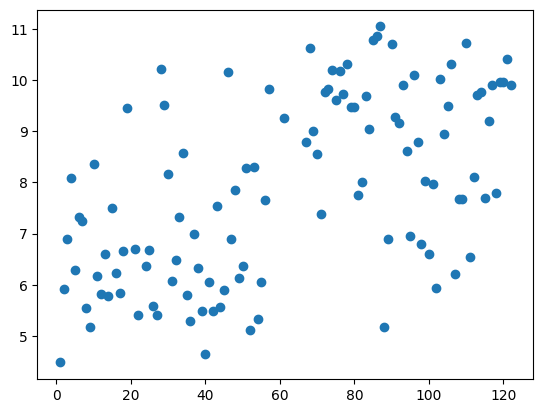

In [9]:
plt.scatter(pos_dat['Run_order'],pos_dat['pos_mz_938.1979761'])

In [10]:
pos_dat

,MS_id,Run_order,Batch,QC,pos_mz_70.01279495,pos_mz_70.06530943,pos_mz_70.06531286,pos_mz_70.06536563,pos_mz_71.0492091,pos_mz_71.04927321,...,pos_mz_976.8197579,pos_mz_977.896065,pos_mz_980.9817221,pos_mz_984.0676893,pos_mz_985.2647745,pos_mz_985.8682309,pos_mz_987.1854049,pos_mz_988.1884514,pos_mz_989.1880072,pos_mz_996.1326799
0,France_Plasma_9,1,1,1,12.538343,13.150924,10.742402,6.607226,9.580268,8.404332,...,8.967587,8.739837,7.361171,6.266319,5.522652,8.546314,14.426558,11.678907,10.142877,9.824538
1,France_Plasma_19,2,1,0,12.057887,12.454060,11.077872,6.523758,10.462323,8.241519,...,10.722093,11.457884,10.605430,9.169921,6.767982,10.413941,8.830098,7.579101,6.955893,9.610757
2,France_Plasma_20,3,1,0,11.961773,12.006367,10.870456,9.455744,10.096219,8.002386,...,8.812501,9.380833,7.876977,6.838874,7.366164,9.530658,10.190917,8.971481,8.078013,10.227105
3,France_Plasma_21,4,1,0,12.088447,13.917289,12.061197,8.553271,10.620183,7.945387,...,8.715334,10.094745,8.650427,7.664513,8.370520,9.184687,10.202734,9.075556,8.344091,9.533301
4,France_Plasma_22,5,1,0,5.623955,6.505935,5.570341,5.893965,9.076724,7.957585,...,8.606101,9.395703,8.200790,6.960063,6.190398,8.357665,11.270087,9.775785,8.597778,8.302175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,France_Plasma_202,118,2,0,11.010274,11.601383,5.964879,7.108333,10.415793,11.232278,...,9.886777,10.747706,9.460808,8.776309,7.731713,9.612037,14.095075,12.619051,11.088896,9.035771
108,France_Plasma_203,119,2,0,11.143251,13.219652,12.829837,7.559425,8.537450,9.408441,...,10.095961,10.880838,10.332660,10.221369,10.436171,9.810373,13.887022,12.315053,10.843255,9.905317
109,France_Plasma_204,120,2,0,10.653092,13.065721,13.262931,7.635327,11.213553,11.334377,...,10.123672,10.912127,10.242221,9.861388,10.423561,9.663205,14.269062,12.755980,11.285444,10.273248
110,France_Plasma_205,121,2,0,9.594323,11.531870,11.577467,7.111173,10.862921,10.953603,...,9.818823,11.052006,10.708924,10.207373,11.632376,9.557398,13.086769,11.544511,10.225296,10.106428


## Run QC-RLSC:

In [11]:
neg_dat_norm = optimized_loess_normalization(neg_dat)
pos_dat_norm = optimized_loess_normalization(pos_dat)
basic_dat_norm = optimized_loess_normalization(basic_dat)

In [12]:
basic_dat_norm = remove_inf_and_nan_features(basic_dat_norm)

## Normalise to sample handling by scaling features with average intensity value of internal standards:

In [13]:
#neg_dat_norm_is = NOMIS(neg_dat_norm,neg_is)
#pos_dat_norm_is = NOMIS(pos_dat_norm,pos_is)
#basic_dat_norm_is = NOMIS(basic_dat_norm,bas_is)

#neg_dat_norm_is = normalise_with_IS(neg_dat_norm,neg_is)
#pos_dat_norm_is = normalise_with_IS(pos_dat_norm,pos_is)
#basic_dat_norm_is = normalise_with_IS(basic_dat_norm,bas_is)

## Visualise results before and after QC-RLSC and IS normalisation to see how the normalisation procedure affected the signal intensities:

CV distribution for original and QC-RLSC normalised negative data:


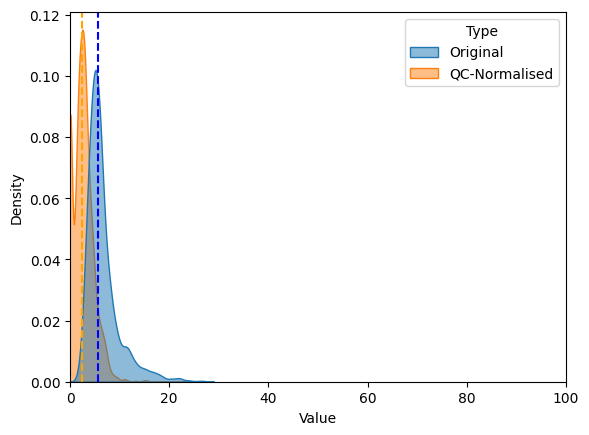

CV distribution for original and QC-RLSC normalised positive data:


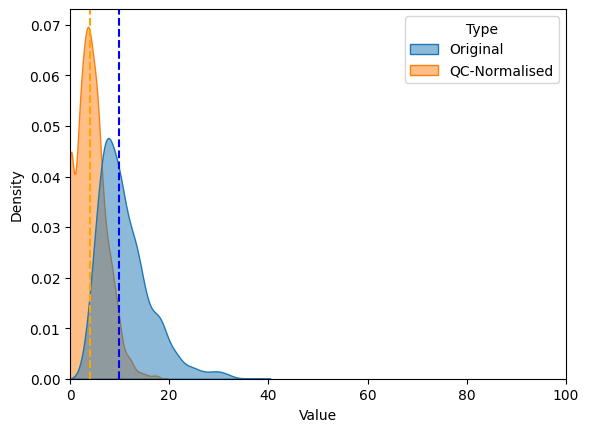

CV distribution for original and QC-RLSC normalised basic data:


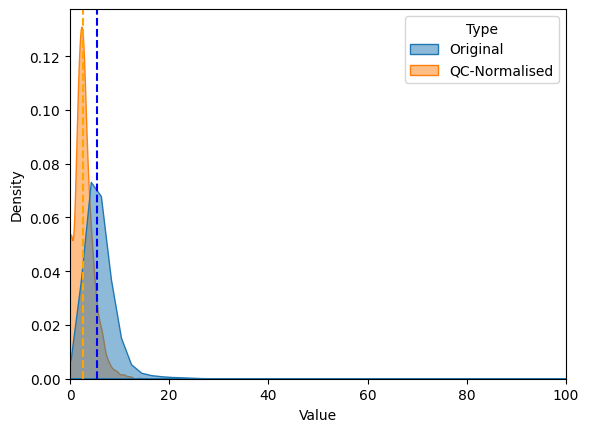

In [14]:
print('CV distribution for original and QC-RLSC normalised negative data:')
neg_dat_norm2, neg_dat_orig2 = remove_unwanted_features(neg_dat_norm,neg_is,neg_dat,30,50)
print('CV distribution for original and QC-RLSC normalised positive data:')
pos_dat_norm2, pos_dat_orig2 = remove_unwanted_features(pos_dat_norm,pos_is,pos_dat,30,50)
print('CV distribution for original and QC-RLSC normalised basic data:')
basic_dat_norm2, basic_dat_orig2 = remove_unwanted_features(basic_dat_norm,bas_is,basic_dat,30,50)

## Check a specific variable to see how it is affected by the normalisation procedure:

Signal intensities before normalisation:


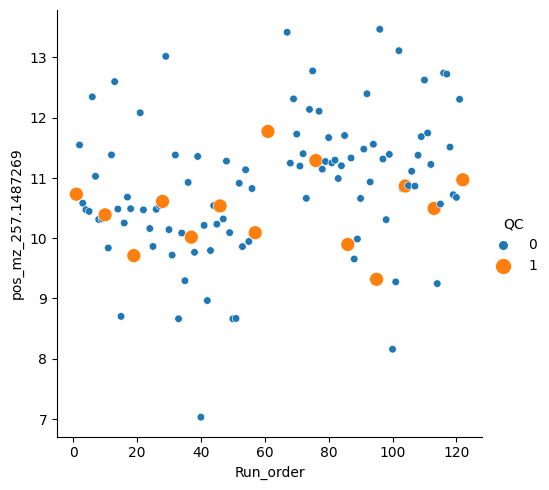

Current status after normalisation:


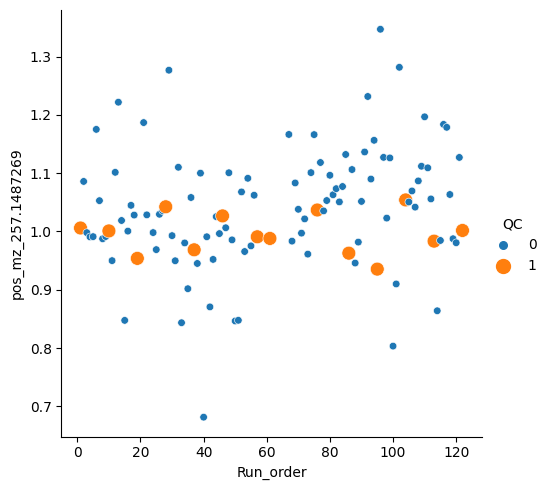

In [15]:
# Choose a random feature id:
var_of_interest = pos_dat_orig2.columns[800]

print('Signal intensities before normalisation:')
# Visualise the original values:
sns.relplot(x="Run_order", y=var_of_interest, hue="QC", sizes = (100,30),size = 'QC',data=pos_dat_orig2)
plt.show()

# Visualise the normalised values:
print('Current status after normalisation:')
sns.relplot(x="Run_order", y=var_of_interest, hue="QC", sizes = (100,30),size = 'QC',data=pos_dat_norm2)
plt.show()

## Remove outliers:

Outlier detection for negative data:


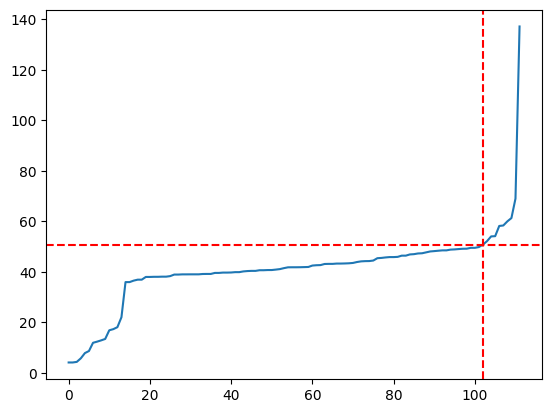

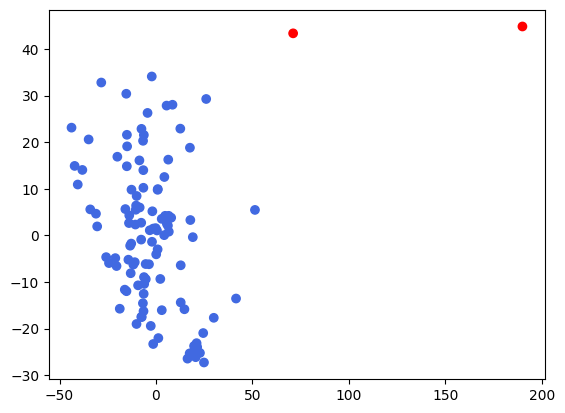

Outlier detection for positive data:


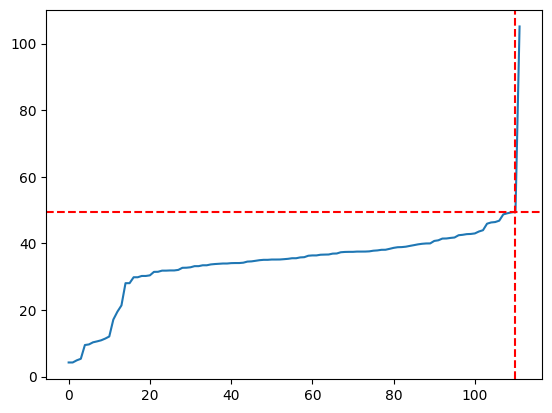

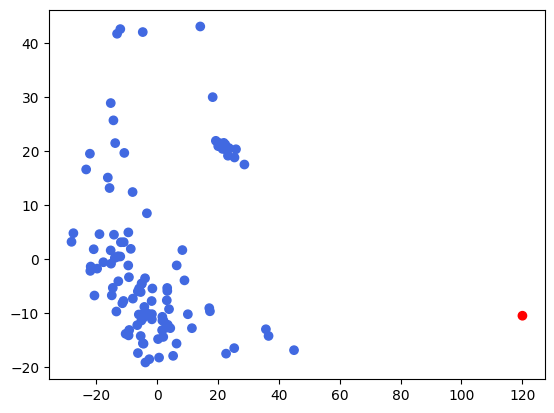

Outlier detection for basic data:


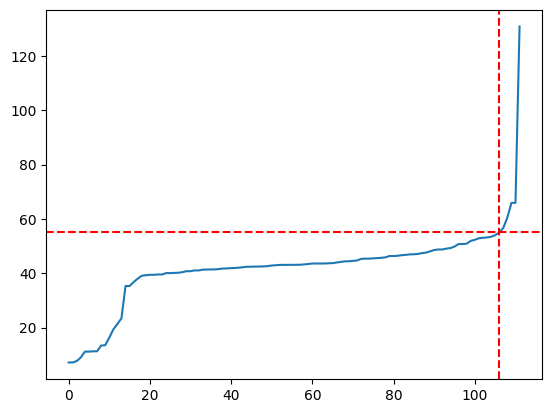

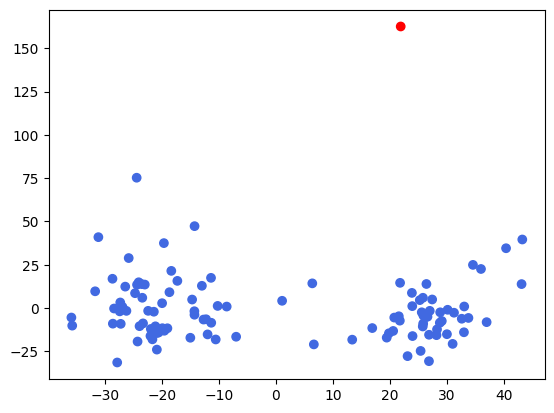

In [16]:
print('Outlier detection for negative data:')
neg_dat_norm3 = outlier_detection_and_removal(neg_dat_norm2, s = 2)
print('Outlier detection for positive data:')
pos_dat_norm3 = outlier_detection_and_removal(pos_dat_norm2, s = 2)
print('Outlier detection for basic data:')
basic_dat_norm3 = outlier_detection_and_removal(basic_dat_norm2, s = 2)

## Compare results before and after outlier removal:

Neg data before outlier removal:


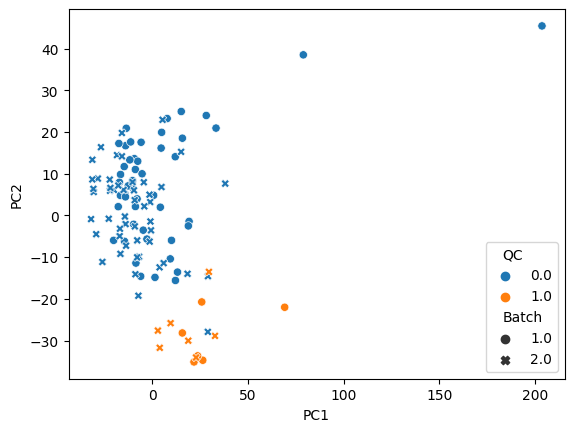

Neg data after outlier removal:


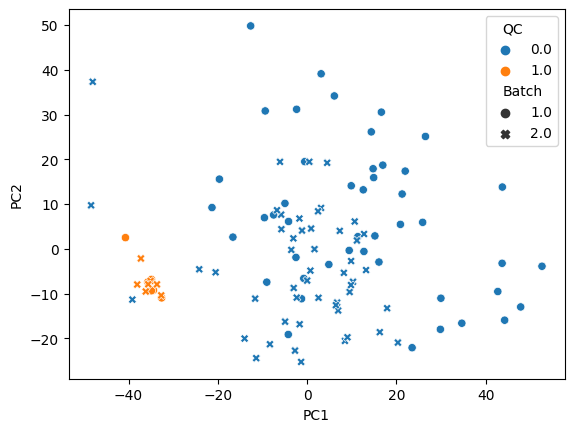

Pos data before outlier removal:


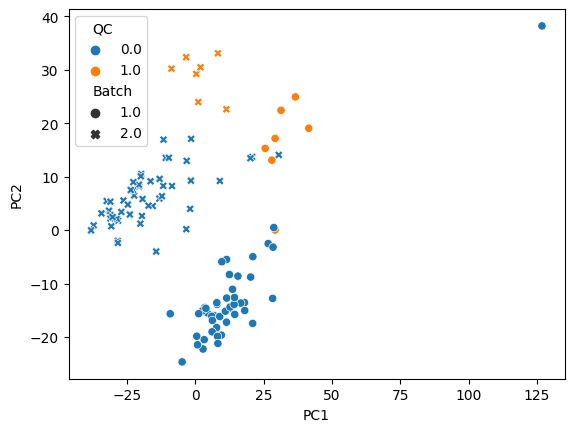

Pos data after outlier removal:


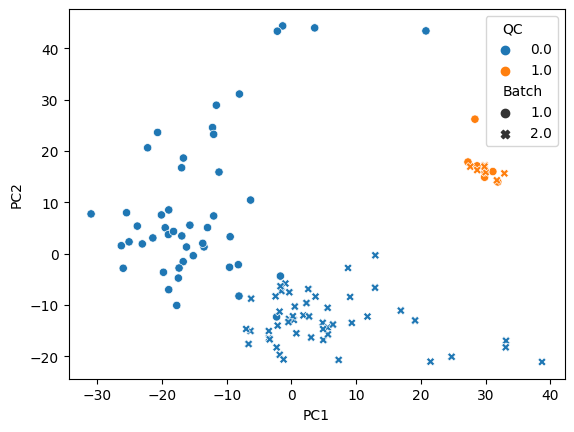

Basic data before outlier removal:


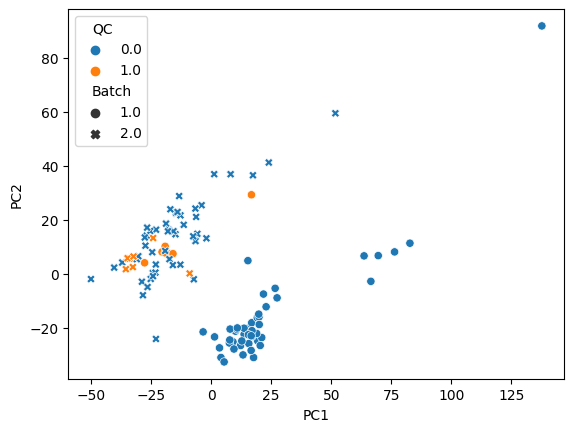

Basic data after outlier removal:


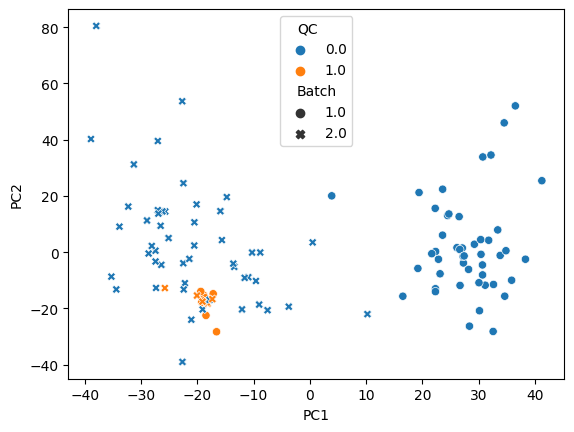

In [17]:
# Original:
print('Neg data before outlier removal:')
PCA_visualisation(neg_dat_orig2)
# Normalised:
print('Neg data after outlier removal:')
PCA_visualisation(neg_dat_norm3)

# Original:
print('Pos data before outlier removal:')
PCA_visualisation(pos_dat_orig2)
# Normalised:
print('Pos data after outlier removal:')
PCA_visualisation(pos_dat_norm3)

# Original:
print('Basic data before outlier removal:')
PCA_visualisation(basic_dat_orig2)
# Normalised:
print('Basic data after outlier removal:')
PCA_visualisation(basic_dat_norm3)

## Removal of residual batch effects:

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Neg data after batch correction:


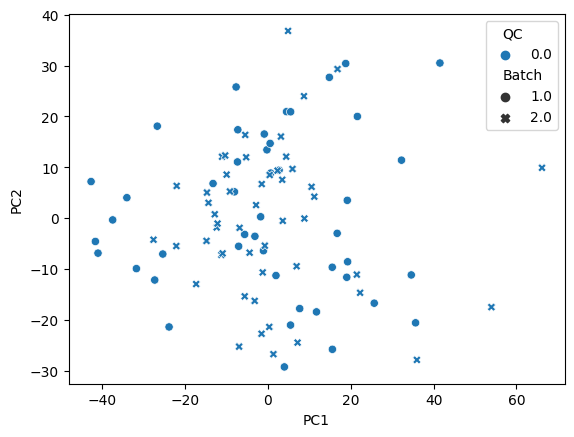

Pos data after batch correction:


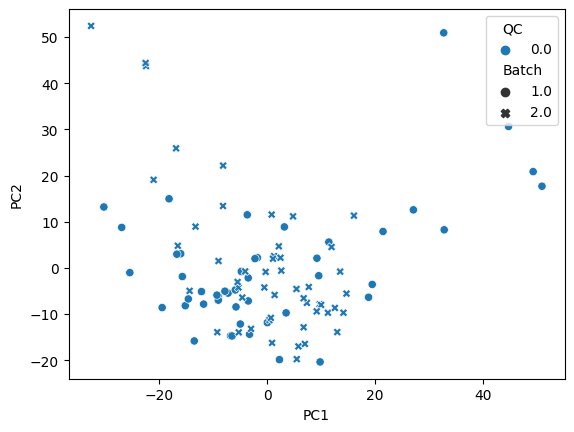

Basic data after batch correction:


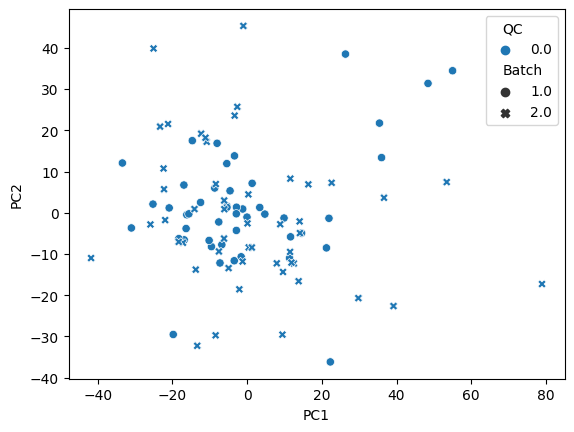

In [18]:
# Remove QC samples from the data:
neg_dat_fin = neg_dat_norm3[neg_dat_norm3['QC'] == 0]
pos_dat_fin = pos_dat_norm3[pos_dat_norm3['QC'] == 0]
basic_dat_fin = basic_dat_norm3[basic_dat_norm3['QC'] == 0]

# Remove batch effects:
neg_dat_corrected = pycombat(neg_dat_fin.iloc[:,4:].T,neg_dat_fin['Batch'].tolist())
pos_dat_corrected = pycombat(pos_dat_fin.iloc[:,4:].T,pos_dat_fin['Batch'].tolist())
basic_dat_corrected = pycombat(basic_dat_fin.iloc[:,4:].T,basic_dat_fin['Batch'].tolist())

# Prepare data:
neg_corrected = pd.concat([neg_dat_fin.iloc[:,:4],neg_dat_corrected.T],axis = 1)
pos_corrected = pd.concat([pos_dat_fin.iloc[:,:4],pos_dat_corrected.T],axis = 1)
basic_corrected = pd.concat([basic_dat_fin.iloc[:,:4],basic_dat_corrected.T],axis = 1)

# Visualise the data after batch-correction:
print('Neg data after batch correction:')
PCA_visualisation(neg_corrected)

print('Pos data after batch correction:')
PCA_visualisation(pos_corrected)

print('Basic data after batch correction:')
PCA_visualisation(basic_corrected)

## Match processed metabolomic data to the metadata, and save to .csv file:

In [19]:
# Match metadata to process metabolomic data:
neg_dat = match_ms_samples_to_patients(neg_corrected,meta_dat_neg)
pos_dat = match_ms_samples_to_patients(pos_corrected,meta_dat_pos)
basic_dat = match_ms_samples_to_patients(basic_corrected,meta_dat_basic)

# Find all the common patients that are left in all datasets:
common_patients = list(set(neg_dat['patient_id'].tolist()).intersection(pos_dat['patient_id'].tolist(), basic_dat['patient_id'].tolist()))
id_neg = [neg_dat['patient_id'].tolist().index(x) for x in common_patients]
id_pos = [pos_dat['patient_id'].tolist().index(x) for x in common_patients]
id_basic = [basic_dat['patient_id'].tolist().index(x) for x in common_patients]

# Merge all datasets into a single dataset:
final_data = pd.concat([neg_dat.iloc[id_neg,4:].reset_index().iloc[:,1:],pos_dat.iloc[id_pos,4:].reset_index().iloc[:,1:],basic_dat.iloc[id_basic,4:].reset_index().iloc[:,1:]],axis = 1)
final_data.index = common_patients

# Merge extremely similar peaks with a pearson correlation of 0.8, and a ppm threshold of 3:
#identical_pairs = identify_extremely_similar_peaks(final_data,0.99,1)
#final_data2 = replace_identical_peaks_with_average(final_data,identical_pairs,all_info)

# Scale and write to csv:
final_scaler = StandardScaler()
scaled_dat = final_scaler.fit_transform(final_data.values)
final_scaled_data = pd.DataFrame(scaled_dat,index = final_data.index,columns = final_data.columns)
print('Final dataset with ',final_scaled_data.shape[0],' samples and ',final_scaled_data.shape[1],'features')
final_scaled_data.to_csv('All_data_normalised_21DEC2023.csv')

Final dataset with  96  samples and  6667 features


In [20]:
final_data.to_csv('All_data_unnormalised_21DEC2023.csv')
#final_data[['neg_mz_104.0356113', 'neg_mz_942.2238965', 'pos_mz_182.0808902', 'bas_mz_248.0223592','pos_mz_253.0978471']]

## Check which patients were removed:

In [21]:
orig_neg_pats = meta_dat_neg['SAMPLE_ID'][meta_dat_neg['SAMPLE_ID'] != 'Pool'].tolist()
final_neg_pats = neg_dat['patient_id'].tolist()
neg_pats_out = list(set(orig_neg_pats) ^ set(final_neg_pats))

In [22]:
orig_pos_pats = meta_dat_pos['SAMPLE_ID'][meta_dat_pos['SAMPLE_ID'] != 'Pool'].tolist()
final_pos_pats = pos_dat['patient_id'].tolist()
pos_pats_out = list(set(orig_pos_pats) ^ set(final_pos_pats))

In [23]:
orig_basic_pats = meta_dat_basic['SAMPLE_ID'][meta_dat_basic['SAMPLE_ID'] != 'Pool'].tolist()
final_basic_pats = basic_dat['patient_id'].tolist()
basic_pats_out = list(set(orig_basic_pats) ^ set(final_basic_pats))

In [24]:
print(neg_pats_out)
print(pos_pats_out)
print(basic_pats_out)

[4, 8]
[4]
[4]
